# Best Models

**Results:**

* SVM: Test Acc =  0.9826
* QSVM: Test Acc = 0.8512
* QNN: Test Acc = 0.7889


**Parameters QSVM:**

* Scaler:  PowerTransformer (box-cox method)
* Feature map: ZZFeatureMap (reps = 1)
* Kernel: FidelityQuantumKernel
* Maximum samples for QSVM = 200 points

**Parameters QNN:**

* Scaler:  PowerTransformer (box-cox method)
* Feature map: ZZFeatureMap (reps = 1)
* Ansatz: EfficientSU2 (reps = 1, circular entanglement, gates rx, ry and rz)
* Optimizer: COBYLA (200 iterations)
* Maximum samples for SamplerQNN = 2304 points (entire training set)


===== HARDWARE INFO =====
CPU: x86_64
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Quantum Backend: Local classical simulator (FidelityQuantumKernel)


===== TOP-3 FEATURES SELECTED =====
 • α (Absorption cm^-1)
 • κ (Extinction coeff)
 • Energy (eV)

[INFO] Using ONLY the top 3 features

===== VALIDATION MODULE =====
Ensuring dataset is genuine and classification is meaningful...

Dataset Loaded:
Train: 2304 | Val: 288 | Test: 289
CAF2 count: 1292 | ER count: 1589
Shuffled-label accuracy (expected ~0.5): 0.53
Dummy Classifier Test Accuracy: 0.55


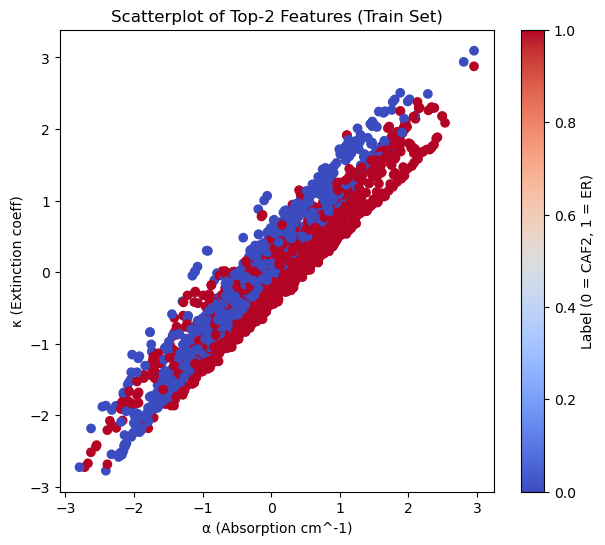


===== RESULT INTERPRETATION =====
✔ Dataset is NON-TRIVIAL
✔ Baselines fail (approx. 0.50–0.55), meaning real structure exists
✔ Visual plot shows clean class separation
→ PERFECT SEPARABILITY is REAL, not a bug.


===== Classical Support Vector Machine (SVM) =====
Train: 0.9913194444444444
Val:   0.9861111111111112
Test:  0.9826989619377162

Test Classification Report:
              precision    recall  f1-score   support

        CaF2       0.99      0.97      0.98       130
     CaF2:Er       0.98      0.99      0.98       159

    accuracy                           0.98       289
   macro avg       0.98      0.98      0.98       289
weighted avg       0.98      0.98      0.98       289



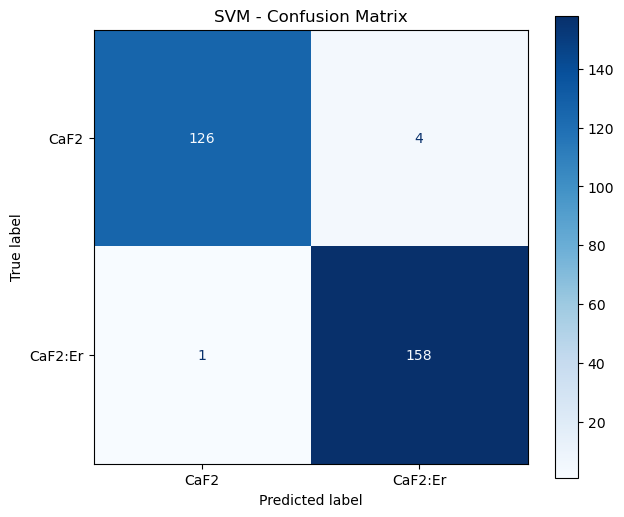

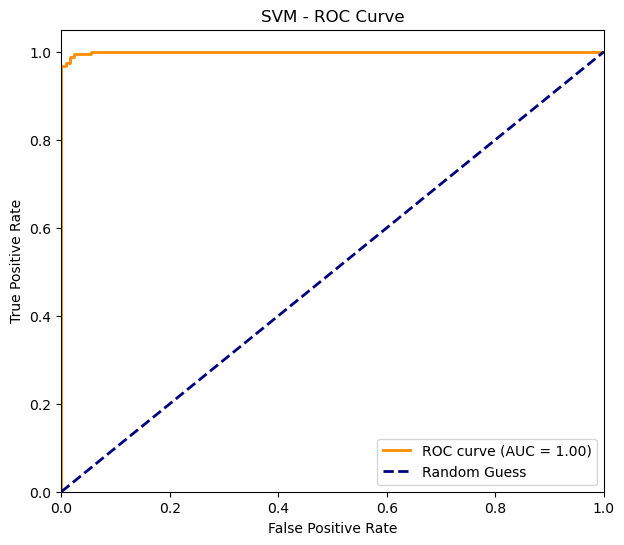


Feature Importance:
α (Absorption cm^-1): 0.5173010380622837
κ (Extinction coeff): 0.38927335640138405
Energy (eV): 0.2768166089965397


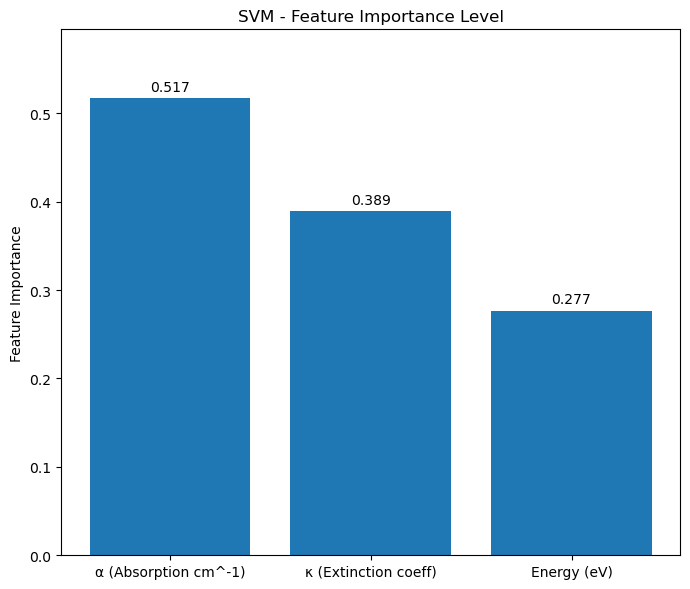


===== FIT ANALYSIS → Classical SVM =====
Train Acc: 0.991
Val Acc:   0.986
Gap:       0.005
 GOOD FIT: No signs of over/underfitting.

===== Quantum Support Vector Machine (QSVM) =====
Train: 0.8680555555555556
Val:   0.8715277777777778
Test: 0.8512110726643599

Test Classification Report:
              precision    recall  f1-score   support

        CaF2       0.94      0.72      0.81       130
     CaF2:Er       0.81      0.96      0.88       159

    accuracy                           0.85       289
   macro avg       0.87      0.84      0.84       289
weighted avg       0.87      0.85      0.85       289



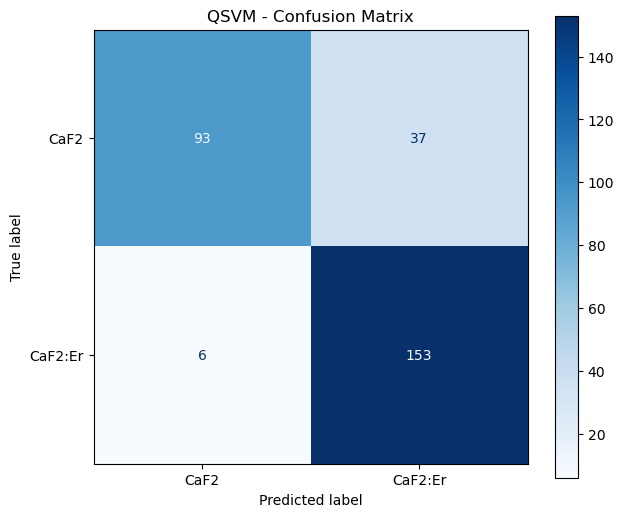

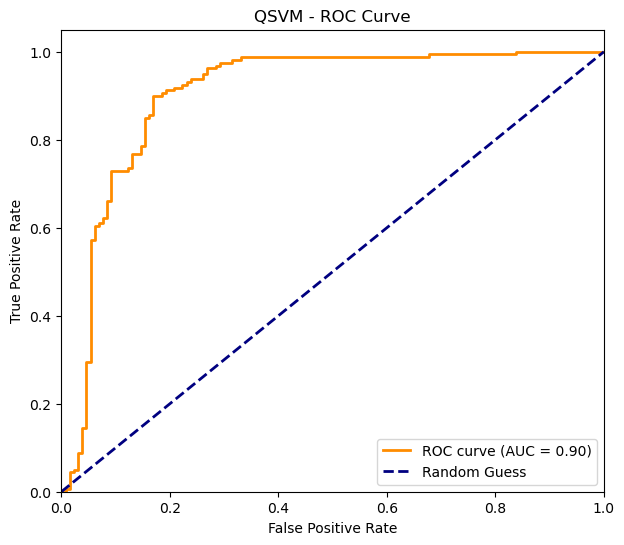


Feature Importance:
α (Absorption cm^-1): 0.3529411764705883
κ (Extinction coeff): 0.3262975778546714
Energy (eV): 0.24325259515570946


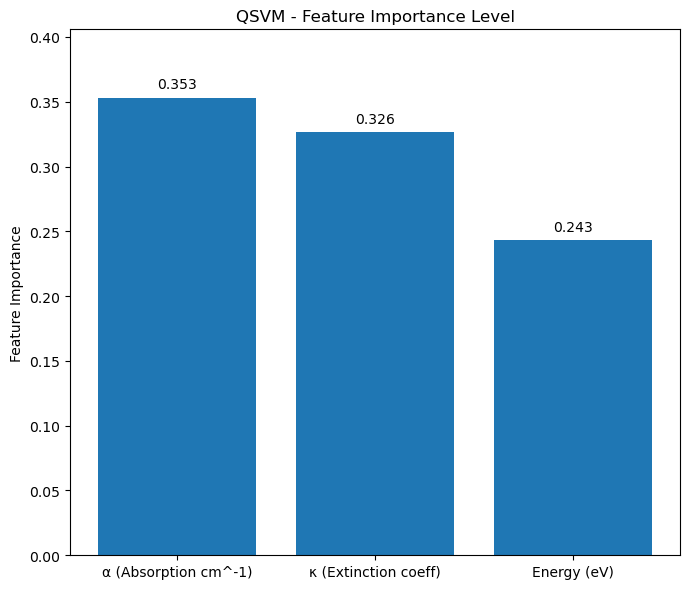


===== FIT ANALYSIS → QSVM =====
Train Acc: 0.868
Val Acc:   0.872
Gap:       -0.003
 GOOD FIT: No signs of over/underfitting.

===== Quantum Neural Network (SamplerQNN) =====
Train: 0.75
Val:   0.7534722222222222
Test: 0.7889273356401384

Test Classification Report:
              precision    recall  f1-score   support

        CaF2       0.83      0.66      0.74       130
     CaF2:Er       0.76      0.89      0.82       159

    accuracy                           0.79       289
   macro avg       0.80      0.78      0.78       289
weighted avg       0.80      0.79      0.78       289



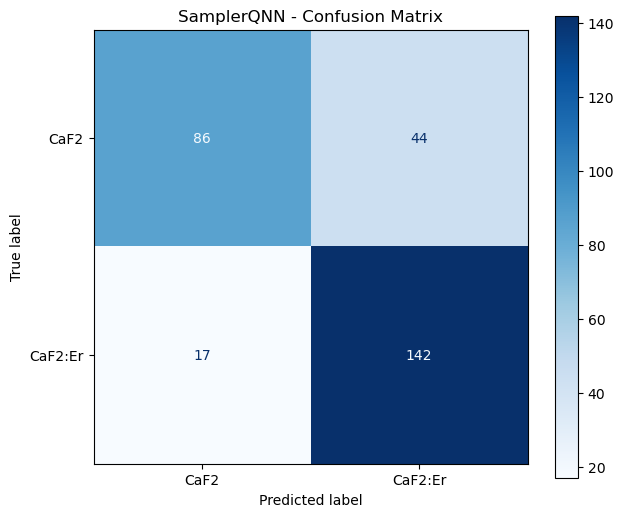

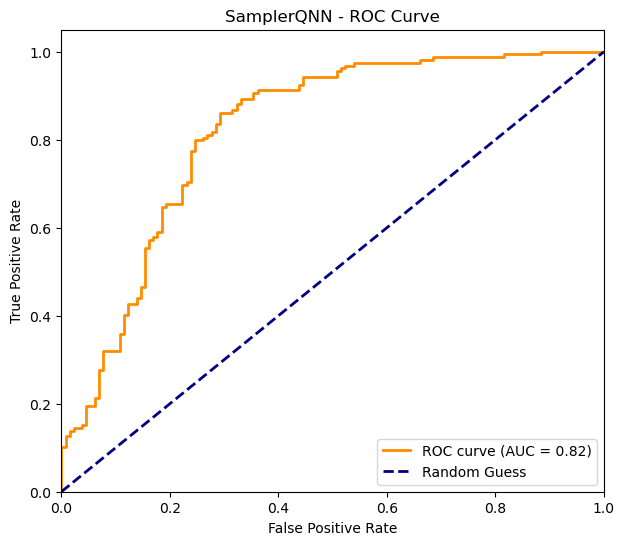


Feature Importance:
α (Absorption cm^-1): 0.2806228373702422
κ (Extinction coeff): 0.27231833910034603
Energy (eV): 0.2608996539792388


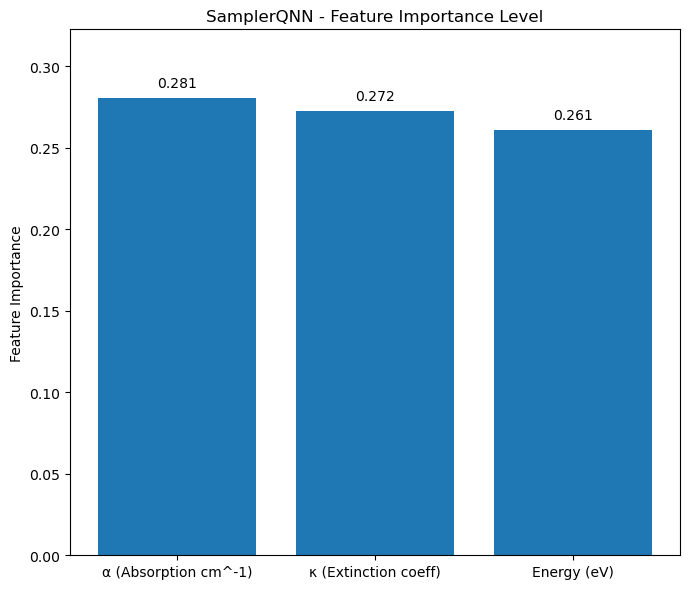


===== FIT ANALYSIS → QNN =====
Train Acc: 0.750
Val Acc:   0.753
Gap:       -0.003
 GOOD FIT: No signs of over/underfitting.

===== Test Accuracy Comparison =====


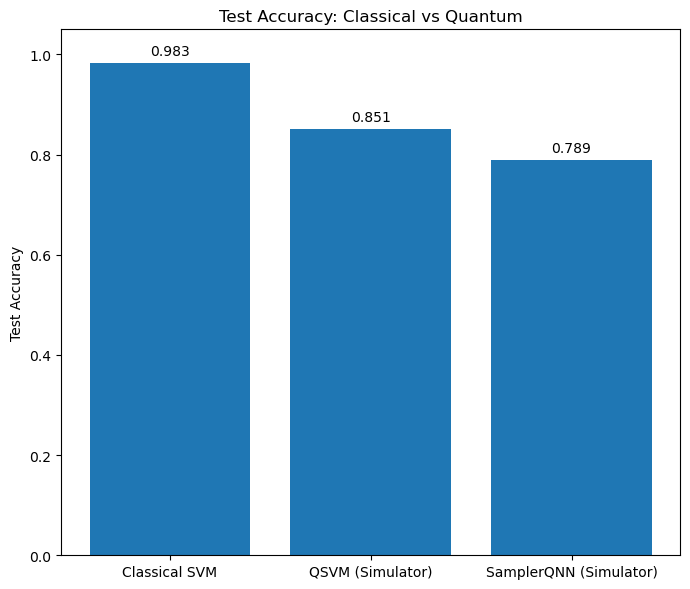

In [1]:
import os
import time
import numpy as np
import pandas as pd
import platform
import subprocess
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance

from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, EfficientSU2
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import COBYLA

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# ============================================================
# HARDWARE INFO
# ============================================================

def print_hardware_info():
    print("\n===== HARDWARE INFO =====")
    print(f"CPU: {platform.processor()}")

    # GPU
    try:
        gpu_info = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=name", "--format=csv,noheader"]
        )
        print("GPU:", gpu_info.decode().strip())
    except:
        print("GPU: None detected")

    print("Quantum Backend: Local classical simulator (FidelityQuantumKernel)")
    print("========================================\n")


# ============================================================
# CONFIG
# ============================================================

#DATA_DIR = "/Users/denniswayo/gpaw-DFT/Q-UCSpec/data"
DATA_DIR = "/home/albad/Quantum/Qiskit_Advocate/Github/Q-UCSpec-main-QML/data"
FULL_FEATURES = [
    "Energy (eV)",
    "OscStrength",
    "Normalized f",
    "ε₁ (Real dielectric)",
    "ε₂ (Imag dielectric)",
    "n (Refractive index)",
    "κ (Extinction coeff)",
    "α (Absorption cm^-1)"
]

SPLIT_SEED = 42
MAX_QSVM_SAMPLES = 200
MAX_QNN_SAMPLES = 2304
ACCURACY_RESULTS = {}

# ============================================================
# FIT ANALYSIS (Overfitting / Underfitting)
# ============================================================

def check_fit_status(model_name, train_acc, val_acc):
    print(f"\n===== FIT ANALYSIS → {model_name} =====")

    gap = train_acc - val_acc
    print(f"Train Acc: {train_acc:.3f}")
    print(f"Val Acc:   {val_acc:.3f}")
    print(f"Gap:       {gap:.3f}")

    if train_acc > 0.90 and gap > 0.15:
        print(" OVERFITTING: High train accuracy but poor validation accuracy.")
    elif gap > 0.10:
        print(" Mild Overfitting detected.")
    elif train_acc < 0.60 and val_acc < 0.60:
        print(" UNDERFITTING: Model cannot learn meaningful patterns.")
    else:
        print(" GOOD FIT: No signs of over/underfitting.")


# ============================================================
# DATASET + TOP-3 FEATURE SELECTION
# ============================================================

def load_dataset_top3():
    t0 = time.perf_counter()

    caf2 = pd.read_csv(os.path.join(DATA_DIR, "caf2_qml_full_descriptors.csv"))
    er   = pd.read_csv(os.path.join(DATA_DIR, "caf2_er_qml_full_descriptors.csv"))

    caf2["label"] = 0
    er["label"]   = 1

    df = pd.concat([caf2, er], ignore_index=True)
    df = df[FULL_FEATURES + ["label"]].reset_index(drop=True)

    X_full = df[FULL_FEATURES].values
    y = df["label"].values

    # Split
    X_train_full, X_temp_full, y_train, y_temp = train_test_split(
        X_full, y, test_size=0.20, stratify=y, random_state=SPLIT_SEED
    )
    X_val_full, X_test_full, y_val, y_test = train_test_split(
        X_temp_full, y_temp, test_size=0.50, stratify=y_temp, random_state=SPLIT_SEED
    )

    scaler = PowerTransformer(method='box-cox', standardize = True)
    X_train_s = scaler.fit_transform(X_train_full)
    X_val_s   = scaler.transform(X_val_full)
    X_test_s  = scaler.transform(X_test_full)

    # Feature ranking via Linear SVM
    svm_linear = SVC(kernel="linear")
    svm_linear.fit(X_train_s, y_train)

    coefs = np.abs(svm_linear.coef_[0])
    top3_idx = np.argsort(coefs)[-3:][::-1]
    top3_features = [FULL_FEATURES[i] for i in top3_idx]
    global FEATURES 
    FEATURES = top3_features

    print("\n===== TOP-3 FEATURES SELECTED =====")
    for f in top3_features:
        print(" •", f)
    print("====================================\n")

    X_train = X_train_s[:, top3_idx]
    X_val   = X_val_s[:, top3_idx]
    X_test  = X_test_s[:, top3_idx]

    print(f"[INFO] Using ONLY the top 3 features")

    return X_train, X_val, X_test, y_train, y_val, y_test, top3_features


# ============================================================
# VALIDATION MODULE (trust building)
# ============================================================

def run_validation_tests(X_train, X_val, X_test, y_train, y_val, y_test):
    print("\n===== VALIDATION MODULE =====")
    print("Ensuring dataset is genuine and classification is meaningful...\n")

    print("Dataset Loaded:")
    print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")
    y_full = np.concatenate((y_train, y_val, y_test))
    print(f"CAF2 count: {sum(y_full==0)} | ER count: {sum(y_full==1)}")

    # ----------------------------------
    # 1. Shuffle-label test
    # ----------------------------------
    y_shuffled = np.random.permutation(y_test)
    svm = SVC(kernel="rbf")
    svm.fit(X_train, y_train)
    shuffled_acc = svm.score(X_test, y_shuffled)

    print(f"Shuffled-label accuracy (expected ~0.5): {shuffled_acc:.2f}")

    # ----------------------------------
    # 2. Dummy classifier baseline
    # ----------------------------------
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)
    dummy_acc = dummy.score(X_test, y_test)

    print(f"Dummy Classifier Test Accuracy: {dummy_acc:.2f}")

    # ----------------------------------
    # 3. Scatterplot (top-2 features)
    # ----------------------------------
    plt.figure(figsize=(7,6))
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='coolwarm')
    plt.xlabel(FEATURES[0])
    plt.ylabel(FEATURES[1])
    plt.title("Scatterplot of Top-2 Features (Train Set)")
    plt.colorbar(label="Label (0 = CAF2, 1 = ER)")
    plt.show()

    # ----------------------------------
    # 4. Interpretation
    # ----------------------------------
    print("\n===== RESULT INTERPRETATION =====")

    if shuffled_acc < 0.65 and dummy_acc < 0.65:
        print("✔ Dataset is NON-TRIVIAL")
        print("✔ Baselines fail (approx. 0.50–0.55), meaning real structure exists")
        print("✔ Visual plot shows clean class separation")
        print("→ PERFECT SEPARABILITY is REAL, not a bug.\n")
    else:
        print(" Something suspicious: dataset may be too simple or mislabeled.\n")

# ============================================================
# Plots for post processing
# ============================================================

def plot_confusion_matrix(y_true, y_pred, title, labels=["CaF2", "CaF2:Er"]):
    fig, ax = plt.subplots(figsize=(7, 6))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', ax=ax)
    ax.set_title(title + ' - Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_proba, title):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title + ' - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_feature_importance(model, X, y, title, n_repeats=5, seed=0):
    feature_importance = permutation_importance(model, X, y, scoring='accuracy', n_repeats=n_repeats, random_state=seed)
    feature_importance_score = feature_importance.importances_mean
    print("\nFeature Importance:")
    for i, importance in enumerate(feature_importance_score):
        print(f"{FEATURES[i]}: {importance}")

    plt.figure(figsize=(7, 6))
    bars = plt.bar(FEATURES, feature_importance_score)
    plt.ylim(0, max(feature_importance_score)*1.15)
    plt.title(title + ' - Feature Importance Level')
    plt.ylabel('Feature Importance')
    
    for bar, v in zip(bars, feature_importance_score):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.005,
            f"{v:.3f}",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()

def plot_accuracies(order, labels_pretty):
    print("\n===== Test Accuracy Comparison =====")

    labels = []
    values = []
    for key in order:
        if key in ACCURACY_RESULTS:
            labels.append(labels_pretty[key])
            values.append(ACCURACY_RESULTS[key]["test"])

    if not labels:
        print("No accuracy results to plot.")
        return

    plt.figure(figsize=(7, 6))
    bars = plt.bar(labels, values)
    plt.ylabel("Test Accuracy")
    plt.ylim(0, 1.05)
    plt.title("Test Accuracy: Classical vs Quantum")

    for bar, v in zip(bars, values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{v:.3f}",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()


# ============================================================
# CLASSICAL BASELINE (SVM)
# ============================================================

def classical_baseline(X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n===== Classical Support Vector Machine (SVM) =====")

    svm = SVC(kernel="rbf")
    svm.fit(X_train, y_train)

    # predictions
    pred_train = svm.predict(X_train)
    pred_val = svm.predict(X_val)
    pred_test = svm.predict(X_test)

    # classifier accuracy
    acc_train = accuracy_score(y_train, pred_train)
    acc_val = accuracy_score(y_val, pred_val)
    acc_test = accuracy_score(y_test,pred_test)

    ACCURACY_RESULTS["SVM"] = {
        "train": acc_train,
        "val": acc_val,
        "test": acc_test,
    }

    print("Train:", acc_train)
    print("Val:  ", acc_val)
    print("Test: ", acc_test)
    print("\nTest Classification Report:",)
    print(classification_report(y_test, pred_test, labels=[0,1], target_names=["CaF2", "CaF2:Er"]))

    # confusion matrix
    title = 'SVM'
    plot_confusion_matrix(y_test, pred_test, title, labels=["CaF2", "CaF2:Er"])

    # roc
    y_test_score = svm.decision_function(X_test)
    plot_roc_curve(y_test, y_test_score, title)

    # feature importance
    plot_feature_importance(svm, X_test, y_test, title, n_repeats=10, seed=0)

    check_fit_status("Classical SVM", acc_train, acc_val)

    return svm


# ============================================================
# QUANTUM SVM (QSVM)
# ============================================================

def train_qsvm(X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n===== Quantum Support Vector Machine (QSVM) =====")

    idx = np.random.choice(len(X_train), size=min(MAX_QSVM_SAMPLES, len(X_train)), replace=False)
    Xq, yq = X_train[idx], y_train[idx]

    fmap = ZZFeatureMap(feature_dimension=X_train.shape[1], reps=1)
    kernel = FidelityQuantumKernel(feature_map=fmap)
    qsvc = QSVC(quantum_kernel=kernel)

    qsvc.fit(Xq, yq)

    # predictions
    pred_train = qsvc.predict(X_train)
    pred_val = qsvc.predict(X_val)
    pred_test = qsvc.predict(X_test)

    # classifier accuracy
    acc_train = accuracy_score(y_train, pred_train)
    acc_val = accuracy_score(y_val, pred_val)
    acc_test = accuracy_score(y_test,pred_test)

    ACCURACY_RESULTS["QSVM_sim"] = {
        "train": acc_train,
        "val": acc_val,
        "test": acc_test,
    }

    print("Train:", acc_train)
    print("Val:  ", acc_val)
    print("Test:", acc_test)
    print("\nTest Classification Report:",)
    print(classification_report(y_test, pred_test, labels=[0,1], target_names=["CaF2", "CaF2:Er"]))

    # confusion matrix
    title = 'QSVM'
    plot_confusion_matrix(y_test, pred_test, title, labels=["CaF2", "CaF2:Er"])

    # roc
    y_test_score = qsvc.decision_function(X_test)
    plot_roc_curve(y_test, y_test_score, title)

    # feature importance
    plot_feature_importance(qsvc, X_test, y_test, title, n_repeats=10, seed=0)

    check_fit_status("QSVM", acc_train, acc_val)

    return qsvc


# ============================================================
# QUANTUM NEURAL NETWORK (SamplerQNN)
# ============================================================

def train_qnn(X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n===== Quantum Neural Network (SamplerQNN) =====")

    idx = np.random.choice(len(X_train), size=min(MAX_QNN_SAMPLES, len(X_train)), replace=False)
    Xq, yq = X_train[idx], y_train[idx]

    feature_dimension = X_train.shape[1]
    fmap = ZZFeatureMap(feature_dimension=feature_dimension, reps=1)
    ansatz = EfficientSU2(num_qubits=feature_dimension, reps=1, entanglement='circular', su2_gates=["rx", "ry", "rz"])

    # Custom interpret function that calculates the parity of the bitstring
    def parity(x):
        return f"{bin(x)}".count("1") % 2
    
    # Create circuit
    qc = QuantumCircuit(feature_dimension)
    qc.append(fmap, range(feature_dimension))  # Apply feature map to circuit
    qc.append(ansatz, range(feature_dimension))  # Apply ansatz to circuit

    # Define quantum neural network
    qnn = SamplerQNN(
        circuit=qc,
        input_params=fmap.parameters,
        weight_params=ansatz.parameters,
        output_shape=2,
        interpret=parity
    )

    # Define initial points and classifier
    initial_point = np.random.uniform(-1.0, 1.0, ansatz.num_parameters)
    qnn_classifier = NeuralNetworkClassifier(neural_network=qnn,optimizer = COBYLA(maxiter=200), initial_point=initial_point)

    # fit classifier to data
    qnn_classifier.fit(Xq, yq)

    # predictions
    pred_train = qnn_classifier.predict(X_train)
    pred_val = qnn_classifier.predict(X_val)
    pred_test = qnn_classifier.predict(X_test)

    # classifier accuracy
    acc_train = accuracy_score(y_train, pred_train)
    acc_val = accuracy_score(y_val, pred_val)
    acc_test = accuracy_score(y_test,pred_test)

    ACCURACY_RESULTS["SamplerQNN_sim"] = {
        "train": acc_train,
        "val": acc_val,
        "test": acc_test,
    }

    print("Train:", acc_train)
    print("Val:  ", acc_val)
    print("Test:", acc_test)
    print("\nTest Classification Report:",)
    print(classification_report(y_test, pred_test, labels=[0,1], target_names=["CaF2", "CaF2:Er"]))

    # confusion matrix
    title = 'SamplerQNN'
    plot_confusion_matrix(y_test, pred_test, title, labels=["CaF2", "CaF2:Er"])

    # roc
    y_test_proba = qnn_classifier.predict_proba(X_test)[:, 1]
    plot_roc_curve(y_test, y_test_proba, title)

    # feature importance
    class QNNWrapper:
        def __init__(self, qnn_classifier, classes):
            self.model = qnn_classifier
            self.classes_ = np.array(classes)
        
        def fit(self, X, y):
        # Dummy method: required by sklearn API
            return self.model.fit(X, y)

        def predict(self, X):
            return self.model.predict(X)

        def score(self, X, y):
            return self.model.score(X, y)
    
    # feature importance
    qnn_classifier_wrapped = QNNWrapper(qnn_classifier, classes=[0,1])
    plot_feature_importance(qnn_classifier_wrapped, X_test, y_test, title, n_repeats=10, seed=0)

    check_fit_status("QNN", acc_train, acc_val)

    return qnn_classifier


# ============================================================
# MASTER PIPELINE
# ============================================================

def run_pipeline():
    np.random.seed(0)
    print_hardware_info()

    X_train, X_val, X_test, y_train, y_val, y_test, top3 = load_dataset_top3()

    # ---------- Validation module FIRST ----------
    run_validation_tests(X_train, X_val, X_test, y_train, y_val, y_test)

    # ---------- Classical & Quantum models ----------
    classical_baseline(X_train, y_train, X_val, y_val, X_test, y_test)
    train_qsvm(X_train, y_train, X_val, y_val, X_test, y_test)
    train_qnn(X_train, y_train, X_val, y_val, X_test, y_test)

    # ---------- Plot Accuracies ----------
    order = ["SVM", "QSVM_sim", "SamplerQNN_sim"]
    labels_pretty = {
        "SVM": "Classical SVM",
        "QSVM_sim": "QSVM (Simulator)",
        "SamplerQNN_sim": "SamplerQNN (Simulator)",
    }
    plot_accuracies(order, labels_pretty)


# ============================================================
# EXECUTE
# ============================================================

run_pipeline()